**Author:** Ngu (Nathan) Dang

# Rwanda Carbon Dioxide Emission Prediction

## Overview

The ability to accurately monitor carbon emissions is a critical step in the fight against climate change. Precise carbon readings allow researchers and governments to understand the sources and patterns of carbon mass output. While Europe and North America have extensive systems in place to monitor carbon emissions on the ground, there are few available in Africa.

The objective of this challenge is to create a machine learning models using open-source CO2 emissions data from Sentinel-5P satellite observations to predict future carbon emissions.

These solutions may help enable governments, and other actors to estimate carbon emission levels across Africa, even in places where on-the-ground monitoring is not possible.

**Note:** This challenge is a part of 2023 edition of Kaggle's Playground Series, Season 3, Episode 20. This notebook contains materials and insights from a few sources listed below. In general, I combined all the useful things I have learned from the references and made a some changes here and there to see if a decent model can be obtained. Under each section, I put the corresponding reference from which I took inspiration, and you can find the full list of reference below :)

## Table of Contents

1. [Importing The Datasets](#section-1)
2. [Data Visualization & Data Cleaning](@section-2)
3. [Feature Engineering](#section-3)
4. [Model Selection](#section-4)
5. [Model Development](#section-5)
6. [Final Evaluation & Submission](#section-6)
7. [Potential Improvement](#section-7)

## List of Acknowledgement & References

- [[1] Getting Started: EDA](https://www.kaggle.com/code/inversion/getting-started-eda)
- [[2] Getting Started: Modeling](https://www.kaggle.com/code/inversion/getting-started-modeling)
- [[3] Simple & Basic RandomForest CO2 Predictions](https://www.kaggle.com/code/krulll/simple-basic-randomforest-co2-predictions/notebook)
- [[4] Predict CO2 Emission in Rwanda](https://www.kaggle.com/code/roberttrypuz/predict-co2-emissions-in-rwanda)
- [[5] PS3E20 EDA + FE + ML Model](https://www.kaggle.com/code/ashx010/ps3e20-eda-fe-ml-model)
- [[6] Hyperparameter Tuning the Random Forest in Python](https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74)

# 0. Importing Libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import numpy as np
import random
import os
from tqdm.notebook import tqdm

import geopandas as gpd
from shapely.geometry import Point
import folium

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import randint

from sklearn.preprocessing import StandardScaler,QuantileTransformer
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import lightgbm as lgb

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

pd.options.display.float_format = '{:.5f}'.format
pd.options.display.max_rows = None

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/playground-series-s3e20/sample_submission.csv
/kaggle/input/playground-series-s3e20/train.csv
/kaggle/input/playground-series-s3e20/test.csv


In [2]:
# Set seed for reproducability
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

<a id="#section-1"> </a>
# 1. Importing the Dataset

## Data Description

The objective of this challenge is to create machine learning models that use open-source emissions data (from Sentinel-5P satellite observations) to predict carbon emissions.

Approximately 497 unique locations were selected from multiple areas in Rwanda, with a distribution around farm lands, cities and power plants. The data for this competition is split by time; the years 2019 - 2021 are included in the training data, and your task is to predict the CO2 emissions data for 2022 through November.

Seven main features were extracted weekly from Sentinel-5P from January 2019 to November 2022. Each feature (Sulphur Dioxide, Carbon Monoxide, etc) contain sub features such as column_number_density which is the vertical column density at ground level, calculated using the DOAS technique. You can read more about each feature in the below links, including how they are measured and variable definitions. You are given the values of these features in the test set and your goal to predict CO2 emissions using time information as well as these features.

In [3]:
DATA_PATH = '/kaggle/input/playground-series-s3e20'
# Load files
train = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
test = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'))
samplesubmission = pd.read_csv(os.path.join(DATA_PATH, 'sample_submission.csv'))

# Preview train dataset
train.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
0,ID_-0.510_29.290_2019_00,-0.51000,29.29000,2019,0,-0.00011,0.60302,-0.00007,0.25567,-98.59389,...,3664.43622,61085.80957,2615.12048,15.56853,0.27229,-12.62899,35.63242,-138.78642,30.75214,3.75099
1,ID_-0.510_29.290_2019_01,-0.51000,29.29000,2019,1,0.00002,0.72821,0.00001,0.13099,16.59286,...,3651.19031,66969.47873,3174.57242,8.69060,0.25683,30.35938,39.55763,-145.18393,27.25178,4.02518
2,ID_-0.510_29.290_2019_02,-0.51000,29.29000,2019,2,0.00051,0.74820,0.00038,0.11002,72.79584,...,4216.98649,60068.89445,3516.28267,21.10341,0.25110,15.37788,30.40182,-142.51954,26.19330,4.23138
3,ID_-0.510_29.290_2019_03,-0.51000,29.29000,2019,3,NaN,NaN,NaN,NaN,NaN,...,5228.50774,51064.54734,4180.97332,15.38690,0.26204,-11.29340,24.38036,-132.66583,28.82915,4.30529
4,ID_-0.510_29.290_2019_04,-0.51000,29.29000,2019,4,-0.00008,0.67630,-0.00005,0.12116,4.12127,...,3980.59812,63751.12578,3355.71011,8.11469,0.23585,38.53226,37.39298,-141.50981,22.20461,4.34732


In [4]:
# Preview test dataset
test.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_pressure,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle
0,ID_-0.510_29.290_2022_00,-0.51000,29.29000,2022,0,NaN,NaN,NaN,NaN,NaN,...,36022.02734,8472.31348,41047.93750,7472.31348,7.93562,0.24077,-100.11379,33.69704,-133.04755,33.77958
1,ID_-0.510_29.290_2022_01,-0.51000,29.29000,2022,1,0.00046,0.69116,0.00032,0.00000,76.23920,...,48539.73724,6476.14732,54915.70858,5476.14716,11.44844,0.29312,-30.51032,42.40259,-138.63282,31.01238
2,ID_-0.510_29.290_2022_02,-0.51000,29.29000,2022,2,0.00016,0.60511,0.00011,0.07987,-42.05534,...,34133.08047,8984.79570,39006.09375,7984.79570,10.75318,0.26713,39.08736,45.93648,-144.78499,26.74336
3,ID_-0.510_29.290_2022_03,-0.51000,29.29000,2022,3,0.00035,0.69692,0.00024,0.20103,72.16957,...,50854.99108,6014.72406,57646.36837,5014.72412,11.76456,0.30468,-24.46513,42.14042,-135.02789,29.60477
4,ID_-0.510_29.290_2022_04,-0.51000,29.29000,2022,4,-0.00032,0.58053,-0.00018,0.20435,76.19086,...,46594.68514,6849.28048,52896.54187,5849.28039,13.06532,0.28422,-12.90785,30.12264,-135.50012,26.27681


In [5]:
# Preview sample submission file
samplesubmission.head()

,ID_LAT_LON_YEAR_WEEK,emission
0,ID_-0.510_29.290_2022_00,81.94000
1,ID_-0.510_29.290_2022_01,81.94000
2,ID_-0.510_29.290_2022_02,81.94000
3,ID_-0.510_29.290_2022_03,81.94000
4,ID_-0.510_29.290_2022_04,81.94000


In [6]:
# Check size and shape of datasets
train.shape, test.shape, samplesubmission.shape

((79023, 76), (24353, 75), (24353, 2))

In [7]:
# Train to test sets ratio
(test.shape[0]) / (train.shape[0] + test.shape[0])

0.23557692307692307

<a id="#section-2"> </a>
# 2. Data Visualization & Data Cleaning

### Reference

- [[1] Getting Started: EDA](https://www.kaggle.com/code/inversion/getting-started-eda)
- [[3] Simple & Basic RandomForest CO2 Predictions](https://www.kaggle.com/code/krulll/simple-basic-randomforest-co2-predictions/notebook)
- [[4] Predict CO2 Emission in Rwanda](https://www.kaggle.com/code/roberttrypuz/predict-co2-emissions-in-rwanda)
- [[5] PS3E20 EDA + FE + ML Model](https://www.kaggle.com/code/ashx010/ps3e20-eda-fe-ml-model)

In this part, we will perform some visualization to get a better understanding of the data.

First of all, we examine the datatype on each column and get the statistical summary of the data.First of all, we examine the datatype on each column and get the statistical summary of the data.

In [8]:
# Visualize the datatype on each column
train.dtypes

ID_LAT_LON_YEAR_WEEK                                         object
latitude                                                    float64
longitude                                                   float64
year                                                          int64
week_no                                                       int64
SulphurDioxide_SO2_column_number_density                    float64
SulphurDioxide_SO2_column_number_density_amf                float64
SulphurDioxide_SO2_slant_column_number_density              float64
SulphurDioxide_cloud_fraction                               float64
SulphurDioxide_sensor_azimuth_angle                         float64
SulphurDioxide_sensor_zenith_angle                          float64
SulphurDioxide_solar_azimuth_angle                          float64
SulphurDioxide_solar_zenith_angle                           float64
SulphurDioxide_SO2_column_number_density_15km               float64
CarbonMonoxide_CO_column_number_density         

In [9]:
# Train statistical summary
train.describe(include = 'all')

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
count,79023,79023.00000,79023.00000,79023.00000,79023.00000,64414.00000,64414.00000,64414.00000,64414.00000,64414.00000,...,78539.00000,78539.00000,78539.00000,78539.00000,78539.00000,78539.00000,78539.00000,78539.00000,78539.00000,79023.00000
unique,79023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,ID_-0.510_29.290_2019_00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,-1.89107,29.88015,2020.00000,26.00000,0.00005,0.83485,0.00004,0.15842,-7.92587,...,5592.37748,59420.29746,4670.43087,19.13924,0.27146,-10.78483,40.43698,-86.80058,27.92598,81.94055
std,NaN,0.69452,0.81038,0.81650,15.29716,0.00027,0.18538,0.00021,0.07136,64.26337,...,1428.50300,9051.16361,1359.25158,13.54705,0.04943,30.37446,6.42822,37.83727,4.40384,144.29965
min,NaN,-3.29900,28.22800,2019.00000,0.00000,-0.00100,0.24182,-0.00089,0.00000,-179.53706,...,1050.66178,24779.03370,1050.49682,1.84453,0.01770,-102.73973,2.99887,-153.46421,10.81829,0.00000
25%,NaN,-2.45100,29.26200,2019.00000,13.00000,-0.00010,0.70582,-0.00008,0.11053,-56.78238,...,4595.40052,53175.77993,3680.85634,9.97457,0.24145,-30.30917,35.82991,-125.99116,24.68676,9.79800
50%,NaN,-1.88200,29.88300,2020.00000,26.00000,0.00002,0.80912,0.00002,0.16185,-12.44173,...,5573.85431,59332.53255,4621.75517,15.13069,0.27275,-12.67391,41.11963,-84.64435,28.33363,45.59345
75%,NaN,-1.30300,30.47100,2021.00000,39.00000,0.00015,0.94279,0.00012,0.21182,72.05999,...,6542.30364,65663.84268,5572.98322,23.78503,0.30289,9.40220,44.44627,-48.13270,31.49988,109.54959


From the above statistical summary, we can deduce some of the following insights:

1. The train data provided ranges from year 2019 to 2021
2. Minimum recorded CO2 emissions is 0.32064 and a maximum of 3167.76800
3. Week of the year starts from 0 to 52
4. The latitude and longitudes ranges show that the regions are mostly within Rwanda

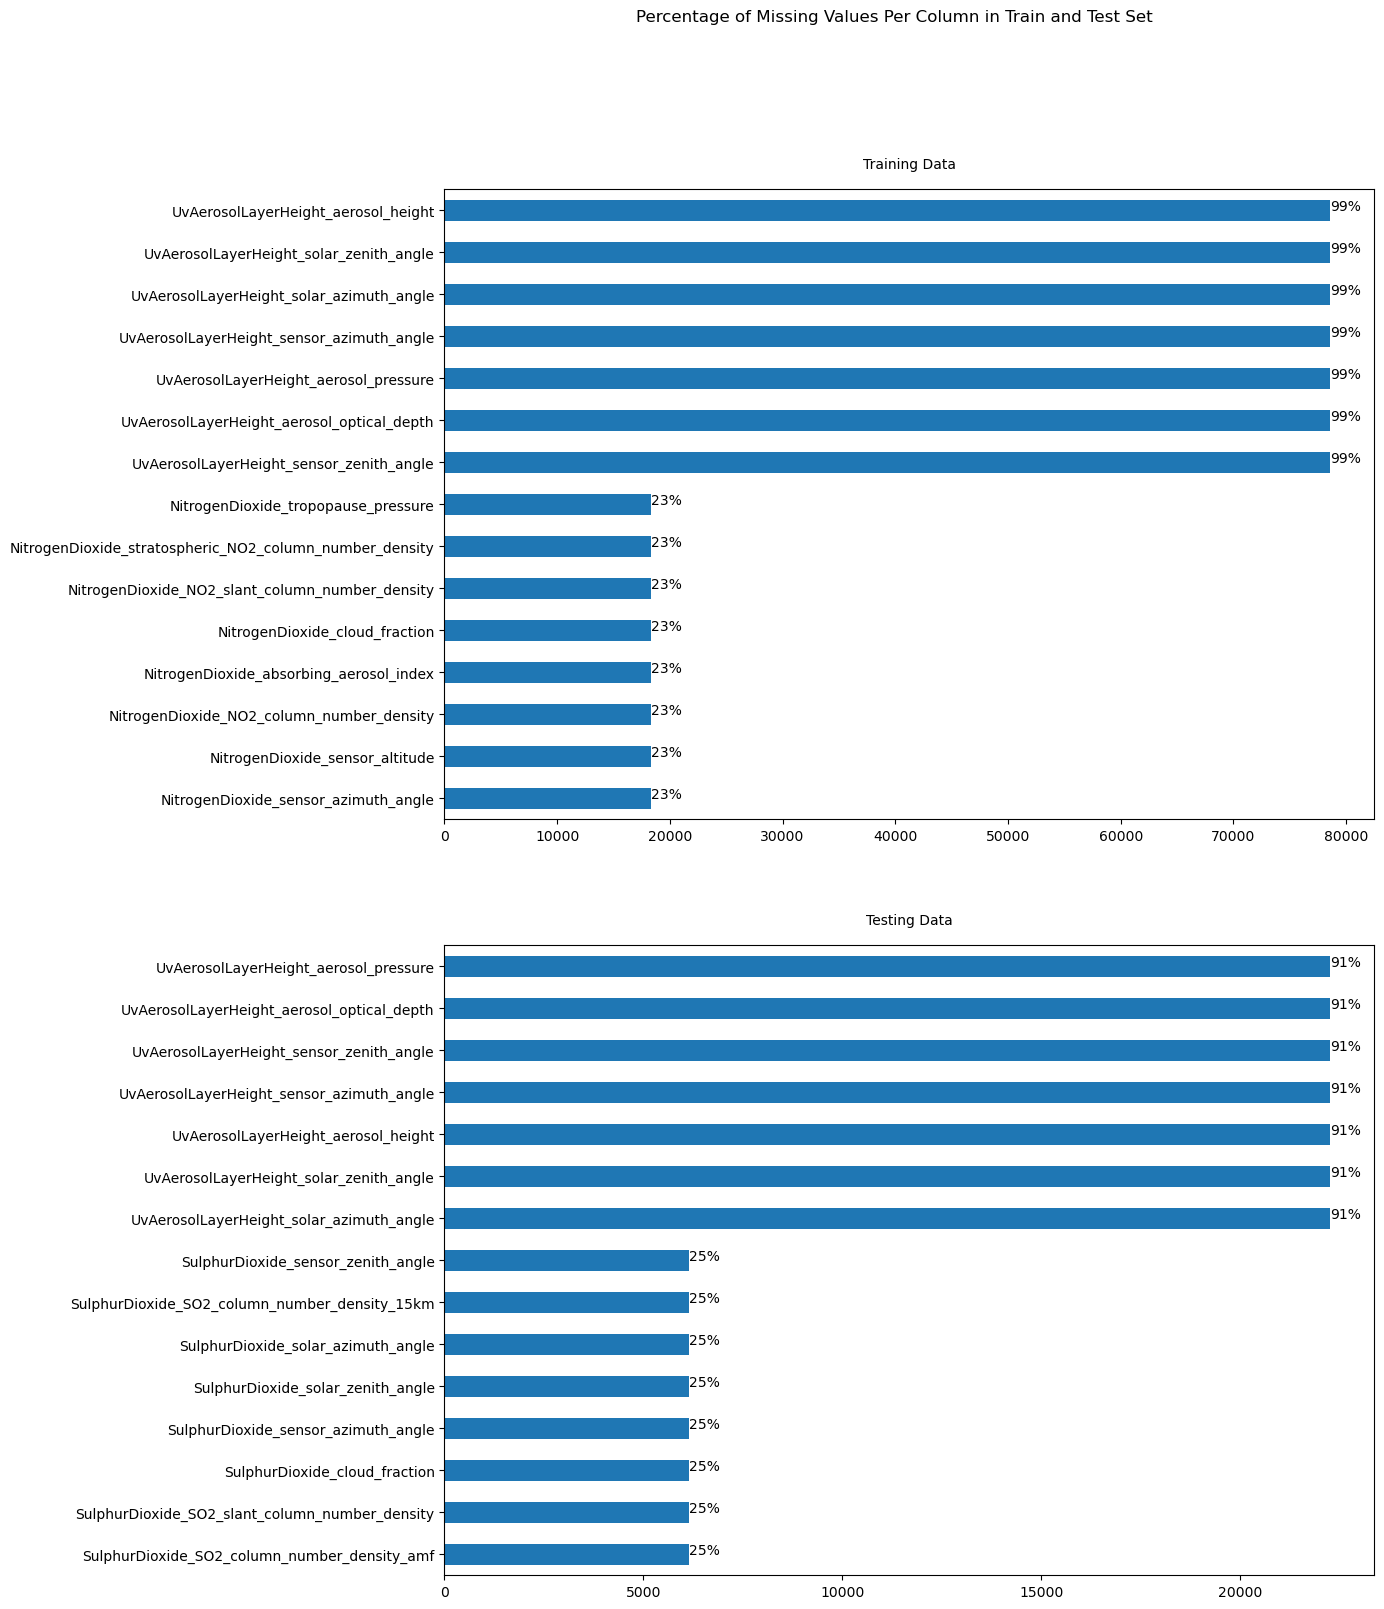

In [10]:
# Plot missing values in train and set
fig = plt.figure(figsize=(12, 18))

ax1 = fig.add_subplot(2, 1, 1)
ax1 = train.isna().sum().sort_values(ascending = False)[:15][::-1].plot(kind = 'barh')
for p in ax1.patches:
    percentage = '{:,.0f}%'.format((p.get_width()/train.shape[0])*100)
    width, height = p.get_width(), p.get_height()
    x = p.get_x() + width + 0.02
    y = p.get_y() + height/2
    ax1.annotate(percentage,(x,y))
ax1.set_title('Training Data', y = 1.02, fontsize = 10)  
    
ax2 = fig.add_subplot(2, 1, 2)
ax2 = test.isna().sum().sort_values(ascending = False)[:15][::-1].plot(kind = 'barh')
for p in ax2.patches:
    percentage = '{:,.0f}%'.format((p.get_width()/test.shape[0])*100)
    width, height = p.get_width(),p.get_height()
    x = p.get_x() + width + 0.02
    y = p.get_y() + height/2
    ax2.annotate(percentage,(x,y))
ax2.set_title('Testing Data', y = 1.02, fontsize = 10)  
    
plt.suptitle('Percentage of Missing Values Per Column in Train and Test Set', fontdict={'size':25})
plt.show()

We will begin the data cleaning with dropping the columns with too many missing values and replace the rest with the average.

In [11]:
# clone the train and test sets
train_clean = train.copy()
test_clean = test.copy()

# Check for duplicate rows just in case
train_clean.duplicated().any(), test_clean.duplicated().any()

(False, False)

In [12]:
# drop the columns in both sets with more than 10% missing values in the training data
threshold = 0.1 * train_clean.shape[0]
for i in train_clean.columns.to_list():
    if train_clean[i].isnull().sum() > threshold:
        train_clean.drop(i, axis=1, inplace=True)
        test_clean.drop(i, axis=1, inplace=True)

In [13]:
# Replace NaN with the average for each column that have less than 90% missing values
train_clean.fillna(train_clean.mean(), inplace=True)
test_clean.fillna(test_clean.mean(), inplace=True)

In [14]:
# Check for missing values to see if our code above works
train_clean.isnull().sum().any(), test_clean.isnull().sum().any()

(False, False)

From the boxplot, we see that some features contain a handful of outliers, and their distributions are skewed on the right. We may want to ignore the corresponding features or scale them so that the modified distributions can be close to normal. 

Now, let's take a look at the distribution of the target value.

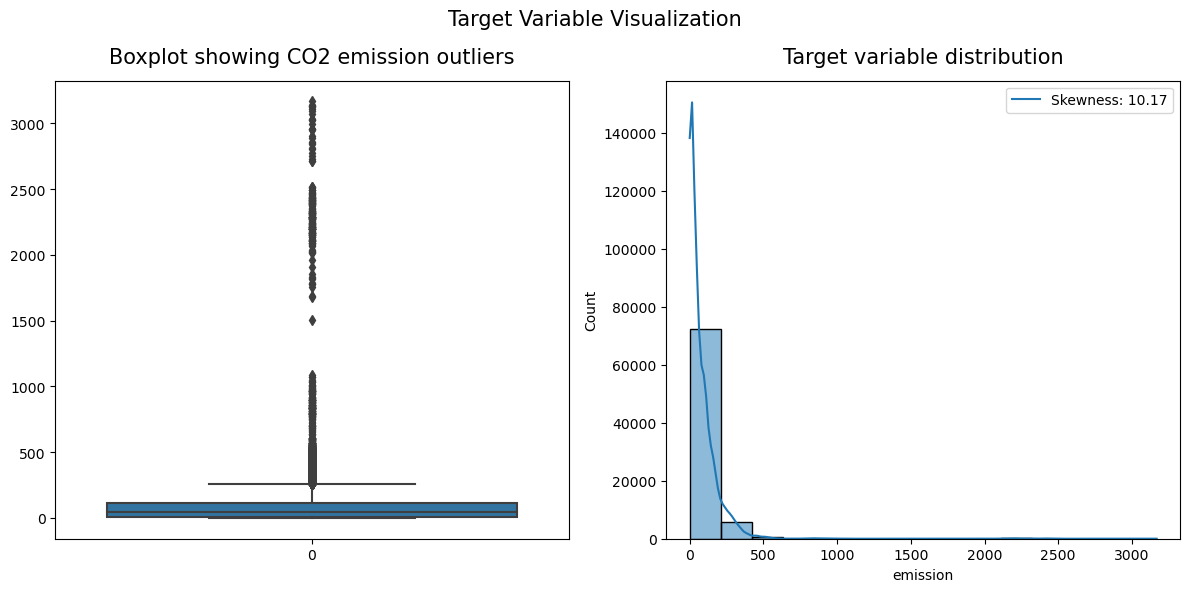

In [15]:
# Plot the distribution and outliers of the target value
fig = plt.figure(figsize=(12, 6))

# Plotting in first axes - boxplot for the CO2 emissions
axs1 = fig.add_subplot(1, 2, 1)
axs1.set_title('Boxplot showing CO2 emission outliers', y = 1.02, fontsize = 15)
axs1 = sns.boxplot(train_clean['emission'])

# Plotting in second axes - target variable distribution
axs2 = fig.add_subplot(1, 2, 2)
axs2.set_title('Target variable distribution', y = 1.02, fontsize = 15)
axs2 = sns.histplot(train_clean['emission'], kde = True, bins = 15)
axs2.legend(['Skewness: {:.2f}'.format(train_clean['emission'].skew())])
            
# Adding a Title for the Overall Figure
fig.suptitle('Target Variable Visualization', fontsize=15)

# Adjust spacing between subplots
fig.tight_layout()

# Show the figure
plt.show()

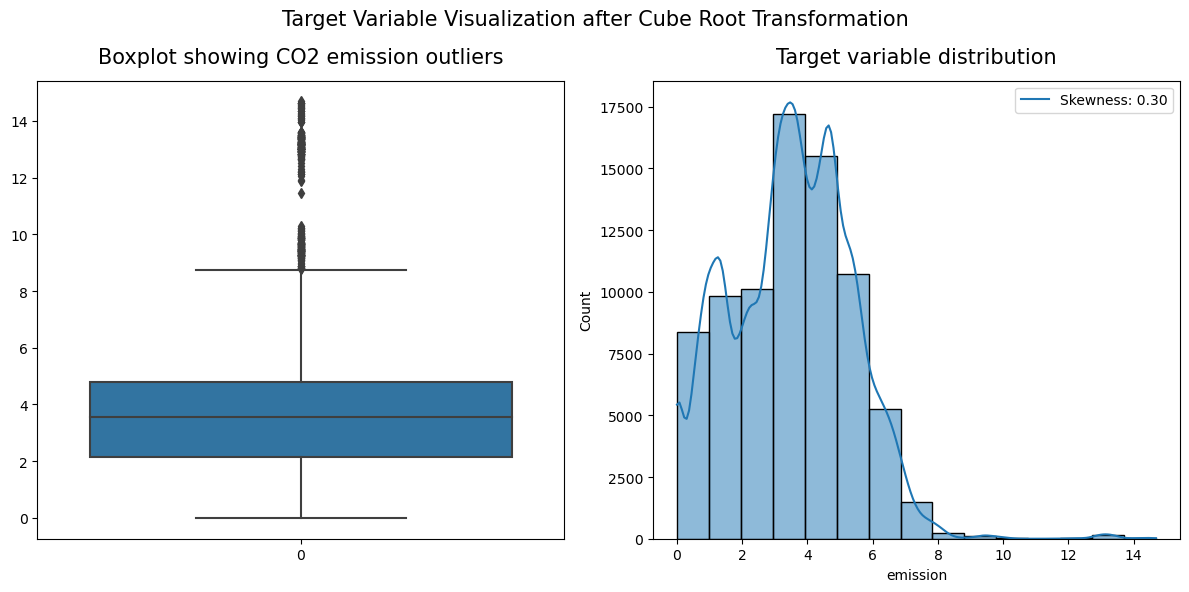

In [16]:
# Plot the distribution and outliers of the transformed target value
fig = plt.figure(figsize=(12, 6))

# Plotting in first axes - boxplot for the CO2 emissions
axs1 = fig.add_subplot(1, 2, 1)
axs1.set_title('Boxplot showing CO2 emission outliers', y = 1.02, fontsize = 15)
axs1 = sns.boxplot(np.cbrt(train_clean['emission']))

# Plotting in second axes - target variable distribution
axs2 = fig.add_subplot(1, 2, 2)
axs2.set_title('Target variable distribution', y = 1.02, fontsize = 15)
axs2 = sns.histplot(np.cbrt(train_clean['emission']), kde = True, bins = 15)
axs2.legend(['Skewness: {:.2f}'.format(np.cbrt(train_clean['emission']).skew())])
            
#Adding a Title for the Overall Figure
fig.suptitle('Target Variable Visualization after Cube Root Transformation', fontsize=15)

# Adjust spacing between subplots
fig.tight_layout()

# Show the figure
plt.show()

Now, we will look at the total number of data points collected across the years 2019-2022 and by weeks to see if we have any inconsistency in data collection.

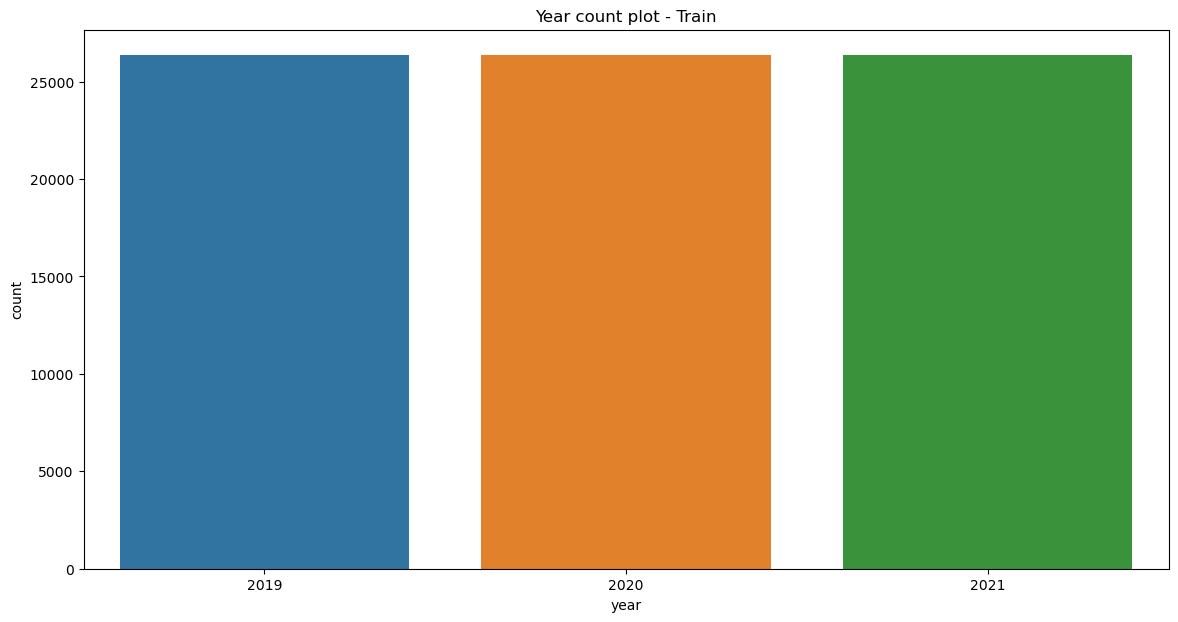

In [17]:
# Year countplot
plt.figure(figsize = (14, 7))
sns.countplot(x = 'year', data = train_clean)
plt.title('Year count plot - Train')
plt.show()

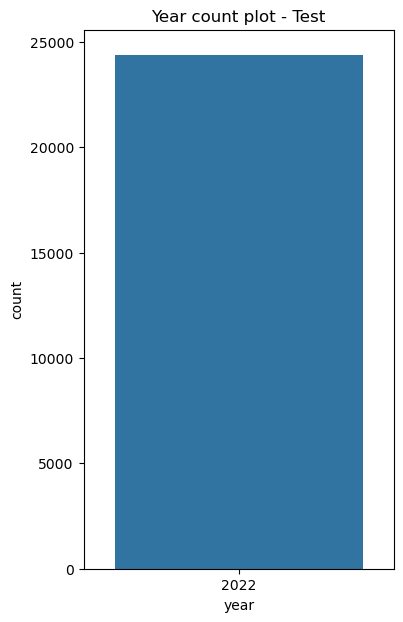

In [18]:
# Year countplot
plt.figure(figsize = (4, 7))
sns.countplot(x = 'year', data = test_clean)
plt.title('Year count plot - Test')
plt.show()

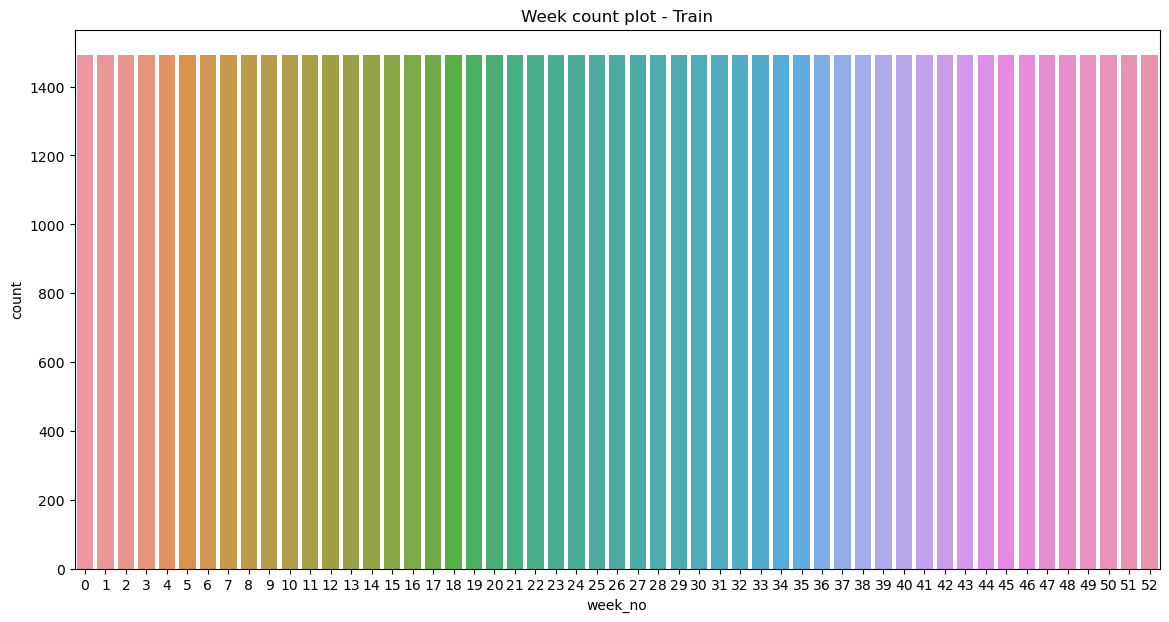

In [19]:
# Week countplot
plt.figure(figsize = (14, 7))
sns.countplot(x = 'week_no', data = train_clean)
plt.title('Week count plot - Train')
plt.show()

We make the following observations:

1. The number of observations of CO2 emissions are the same across the years (2019, 2020, 2021)
2. Year 2022 (in the test set) has fewer number of observations
3. The number of observations of CO2 emissions are relatively the same across the weeks

This insight suggests that we can train our model on the data for 2019 and 2020, then evaluate it on the data for 2021, and then use the final model to predict the emission in 2022. In other words, besides the convention of train-test split with the ratio 70%-30%, for example, we can have our training data containing features and target values in 2019 and 2020. Then, use the features and target values in 2021 to evaluate our model, and once we are happy with the model, we use it to predict the emissions in the given test set which contains features in 2022. 

It is always useful to have a look at the correlation between each feature and the target value (i.e. emission as it can help us determine which features we will keep for the training process and engineer new features from the given ones if needed.

In [20]:
# Top 20 correlated features to the target
top20_corrs = abs(train_clean.corr()['emission']).sort_values(ascending = False).head(20)
top20_corrs

emission                                                   1.00000
longitude                                                  0.10275
Cloud_surface_albedo                                       0.04653
CarbonMonoxide_H2O_column_number_density                   0.04264
CarbonMonoxide_CO_column_number_density                    0.04077
Formaldehyde_tropospheric_HCHO_column_number_density_amf   0.03758
Formaldehyde_tropospheric_HCHO_column_number_density       0.03111
Formaldehyde_solar_azimuth_angle                           0.02876
CarbonMonoxide_solar_azimuth_angle                         0.02593
Ozone_solar_azimuth_angle                                  0.02481
UvAerosolIndex_solar_azimuth_angle                         0.02478
Cloud_solar_azimuth_angle                                  0.02418
Ozone_solar_zenith_angle                                   0.02246
UvAerosolIndex_solar_zenith_angle                          0.02194
Cloud_solar_zenith_angle                                   0.0

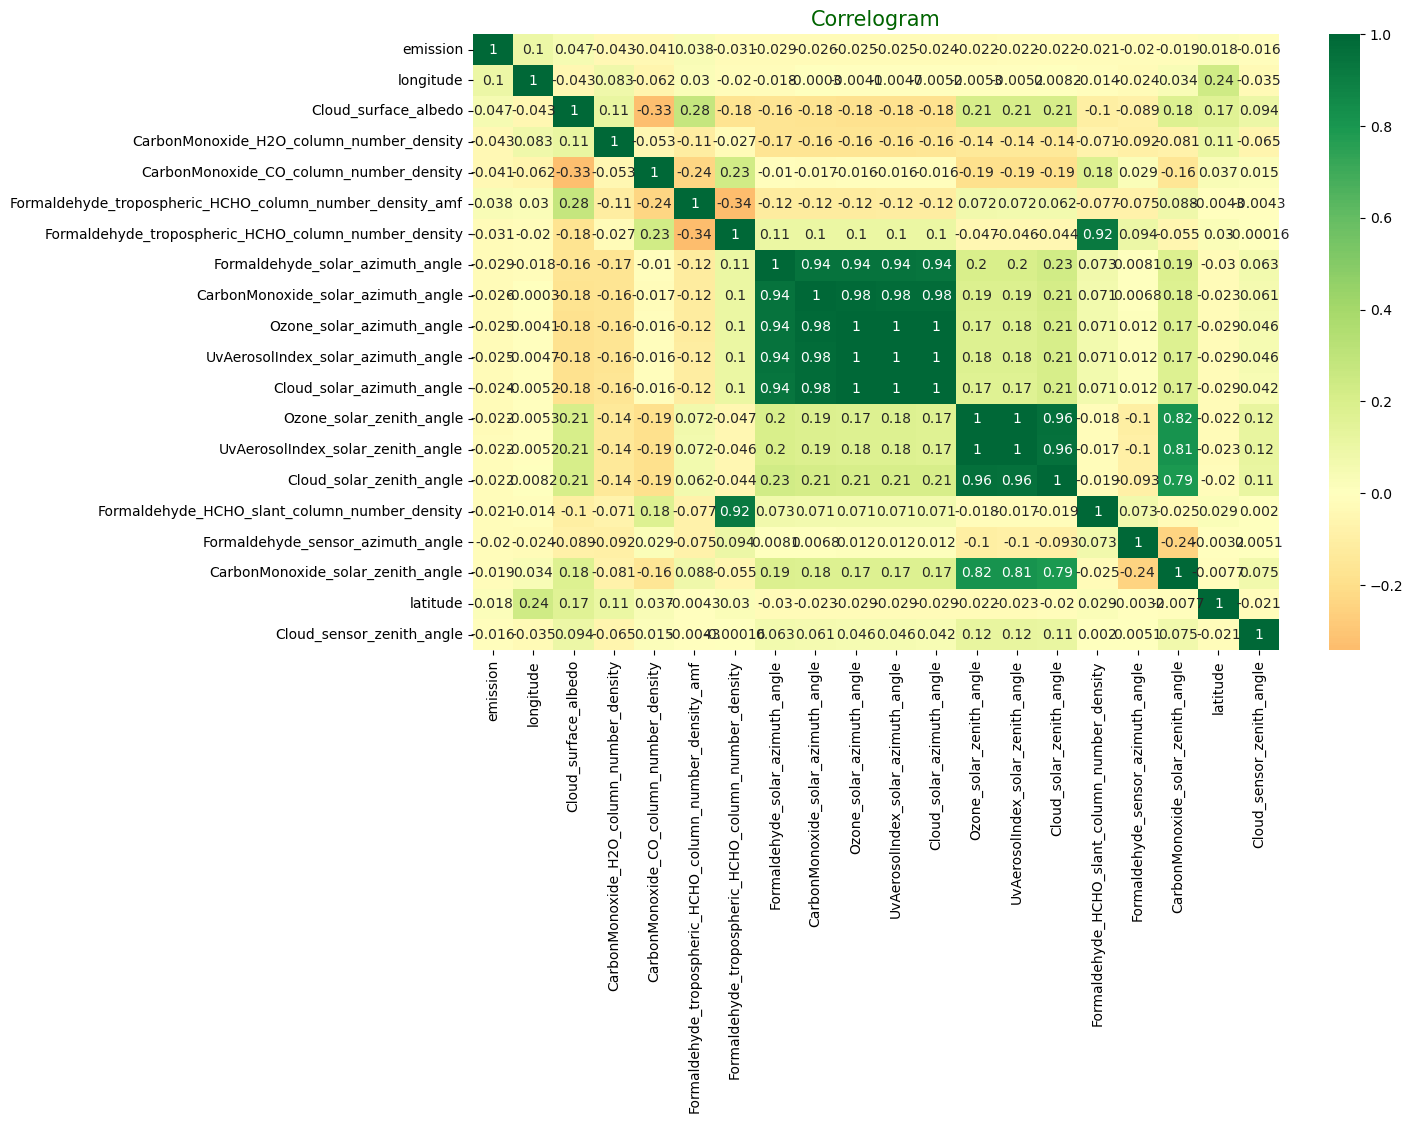

In [21]:
# Quantify correlations between features
corr = train_clean[list(top20_corrs.index)].corr()
plt.figure(figsize = (13, 8))
sns.heatmap(corr, cmap='RdYlGn', annot = True, center = 0)
plt.title('Correlogram', fontsize = 15, color = 'darkgreen')
plt.show()

We observe that some features are highly correlated to one another, and we can drop the to improve the training process.

A bit more information on why we should do this can be found [here.](https://datascience.stackexchange.com/questions/24452/in-supervised-learning-why-is-it-bad-to-have-correlated-features)

In [22]:
# Filter out the features that are highly correlated
threshold = 0.90
train_clean_corr = train_clean.corr()
corr_upper = train_clean_corr.where(np.triu(np.ones(train_clean_corr.shape), k=1).astype(np.bool))
highly_correlated_features = [col for col in corr_upper.columns if any(corr_upper[col] > threshold)]
highly_correlated_features

['Formaldehyde_HCHO_slant_column_number_density',
 'Formaldehyde_solar_azimuth_angle',
 'UvAerosolIndex_solar_azimuth_angle',
 'Ozone_sensor_azimuth_angle',
 'Ozone_sensor_zenith_angle',
 'Ozone_solar_azimuth_angle',
 'Ozone_solar_zenith_angle',
 'Cloud_cloud_fraction',
 'Cloud_cloud_base_pressure',
 'Cloud_cloud_base_height',
 'Cloud_solar_azimuth_angle',
 'Cloud_solar_zenith_angle']

In [23]:
# Drop the features found above
train_clean.drop(columns=highly_correlated_features, inplace=True)
test_clean.drop(columns=highly_correlated_features, inplace=True)

Now, we examine the distribution of the features and whether they contain outliers.

In [24]:
features = train_clean.columns.to_list()

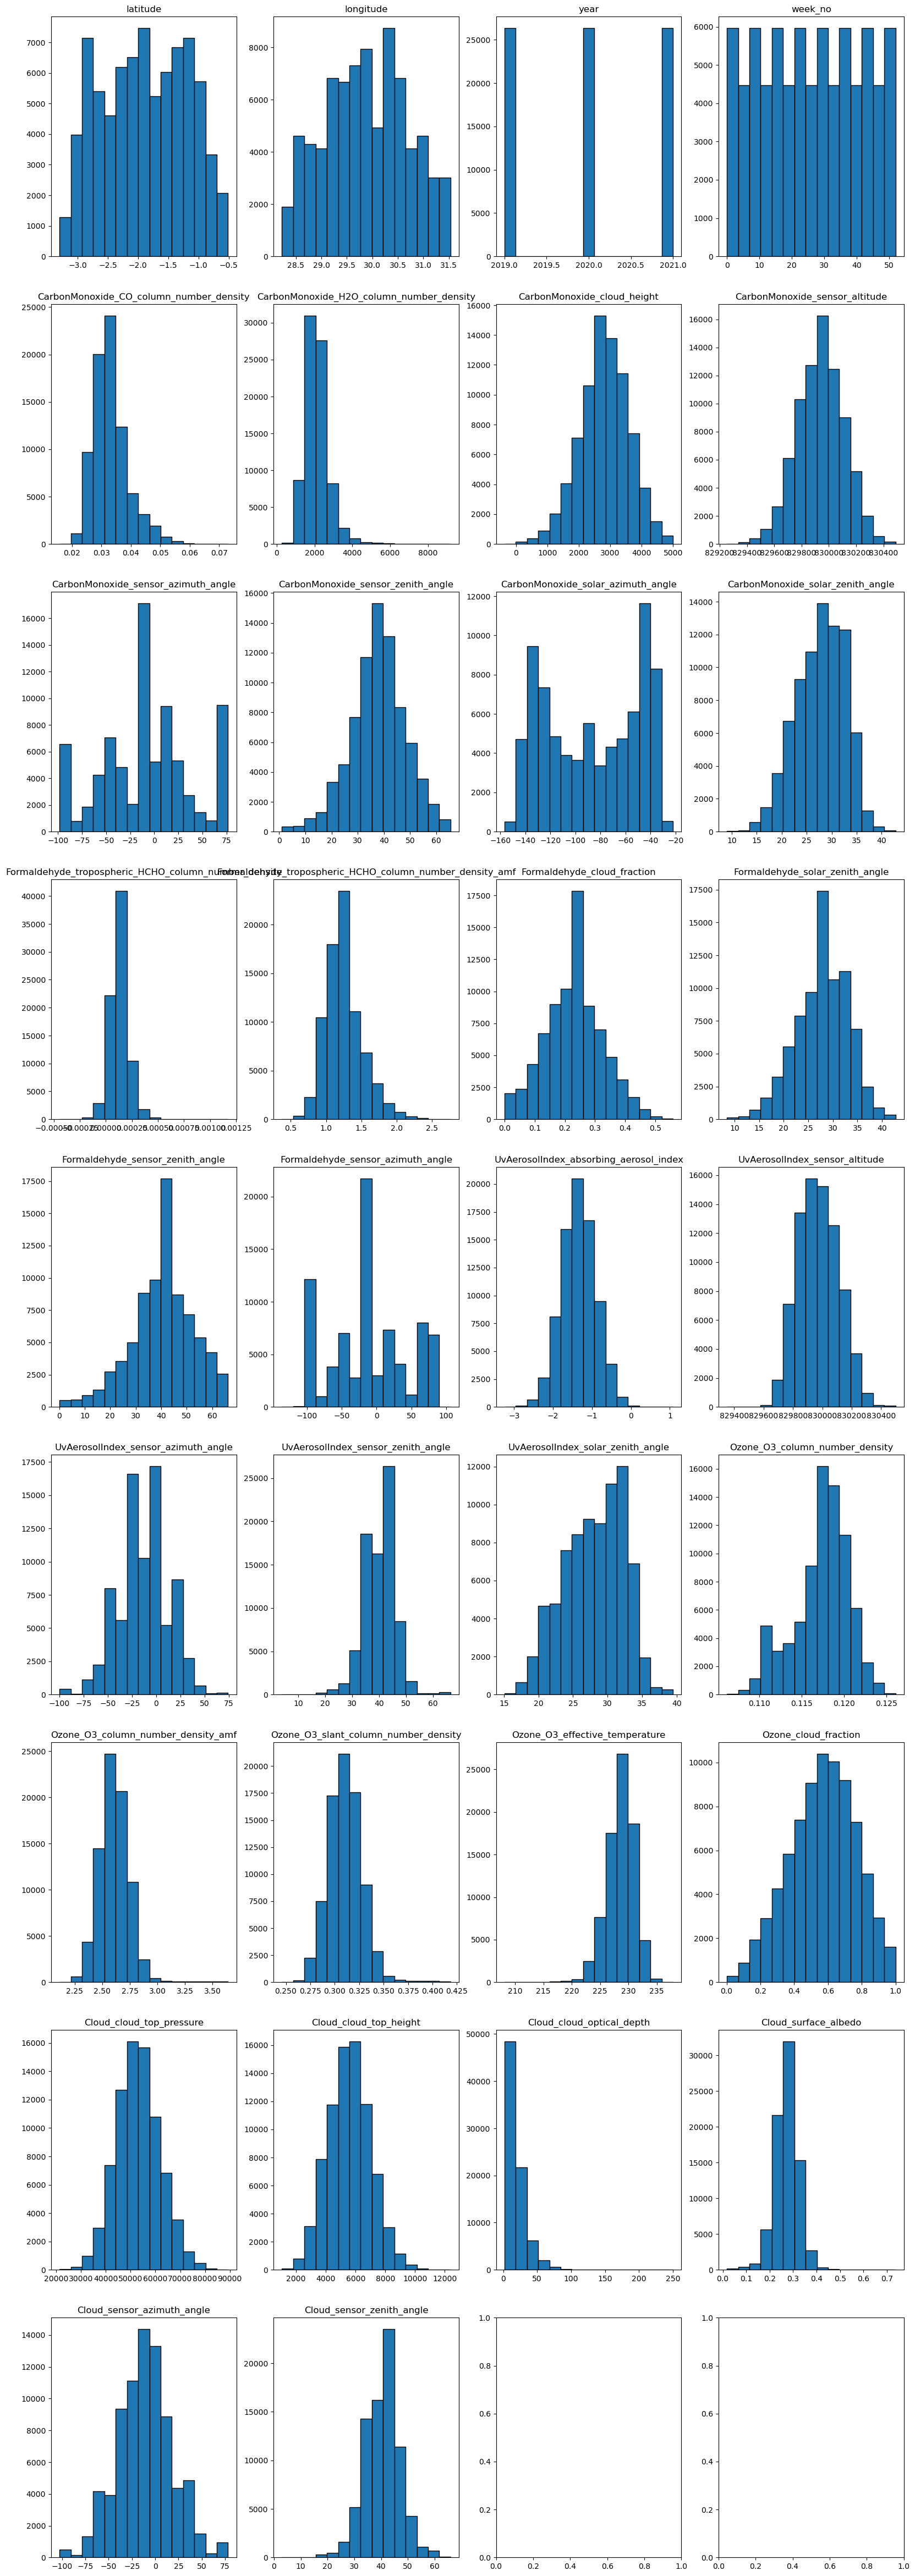

In [25]:
f,ax = plt.subplots(9, 4, figsize=(20,60))
for i,ax in zip(features[1:-1], ax.reshape(-1)):
    ax.set_title(i)
    ax.hist(data=train_clean, x=i, edgecolor='black', bins=15)
plt.show()

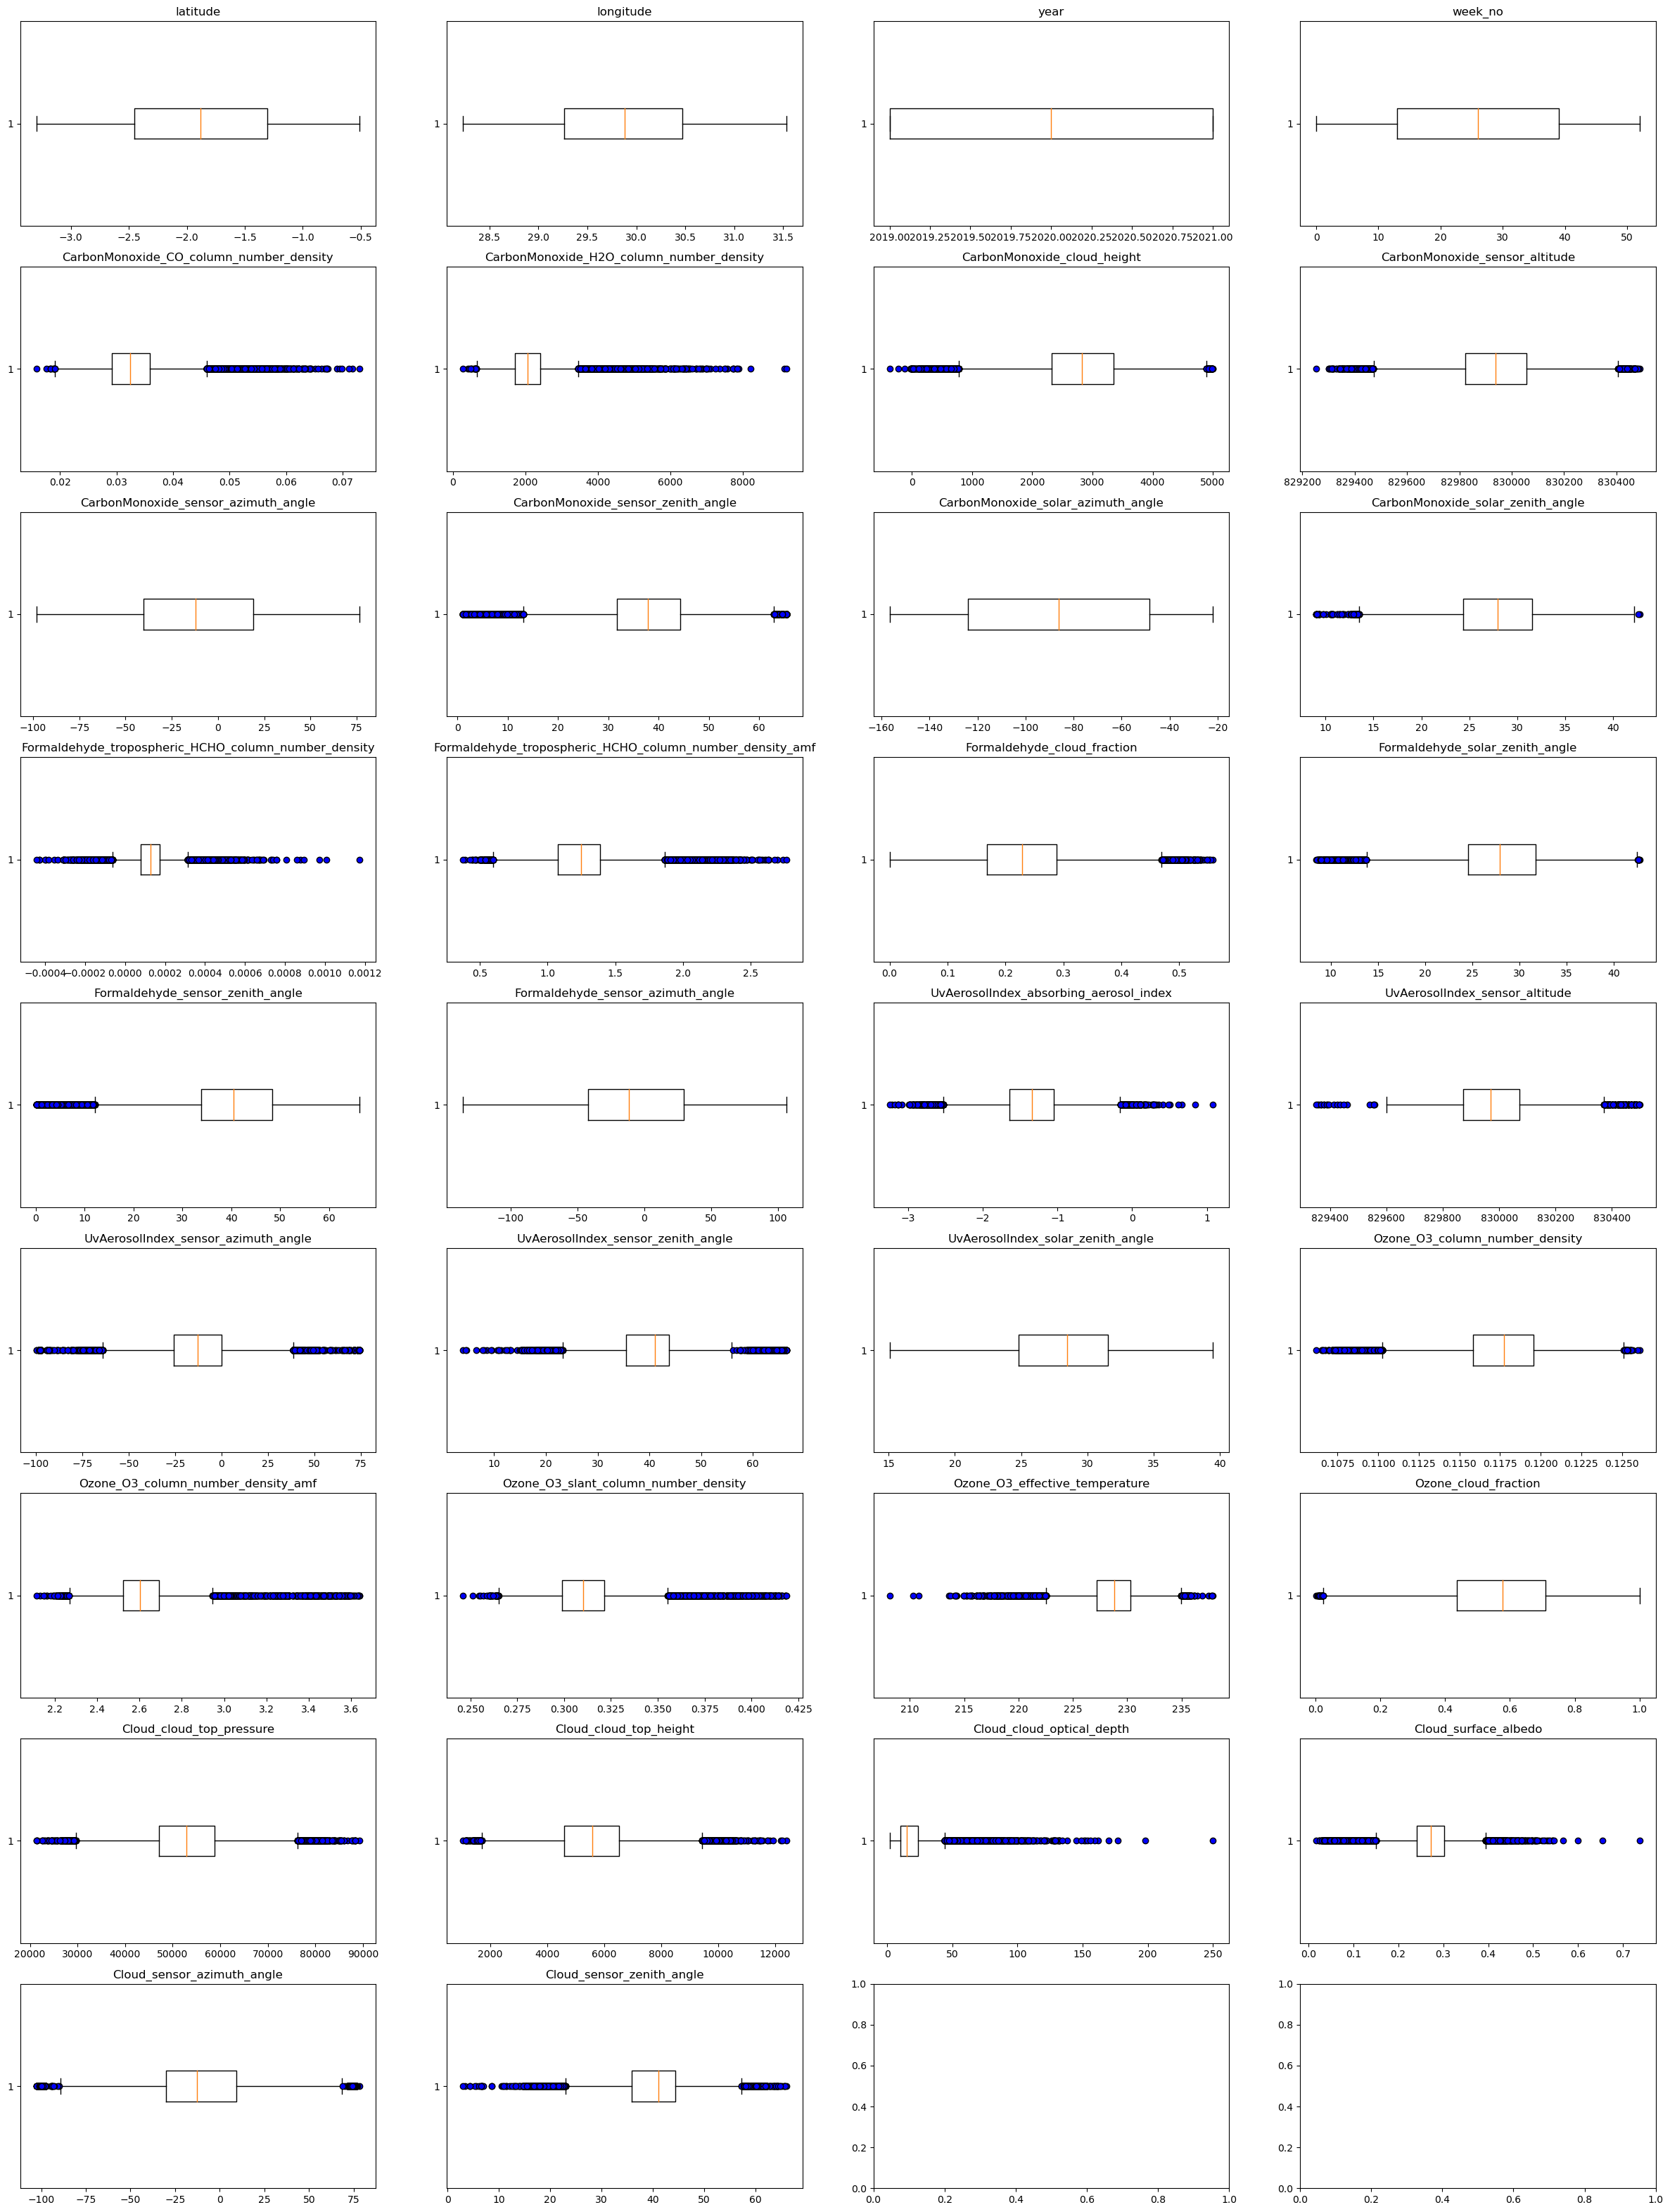

In [26]:
f,ax = plt.subplots(9, 4, figsize=(30,40))
for i, ax in zip(features[1:-1], ax.reshape(-1)):
    flierprops = dict(marker='o', markerfacecolor='blue', markeredgecolor='black', markersize=6)
    ax.boxplot(x = train_clean[i], flierprops=flierprops, vert=False)
    ax.set_title(i)
plt.show()

From the plots above, we can choose features whose distributions somewhat look like a normal distribution and perhaps give useful information and correlated well with the target value.

Such features can be:

- Latitude
- Longtitude
- Year (even though the distribution of the year doesn't look normal, but it is a crucial factor for understanding the pattern of the data as we have seen so far)
- Week_no (same reason as above)
- Formaldehyde_tropospheric_HCHO_column_number_density_amf
- CarbonMonoxide_H2O_column_number_density
- Cloud_surface_albedo 

Finally, we will have a look at the change over time of the CO2 emissions over the years, i.e. Timeseries visualization.

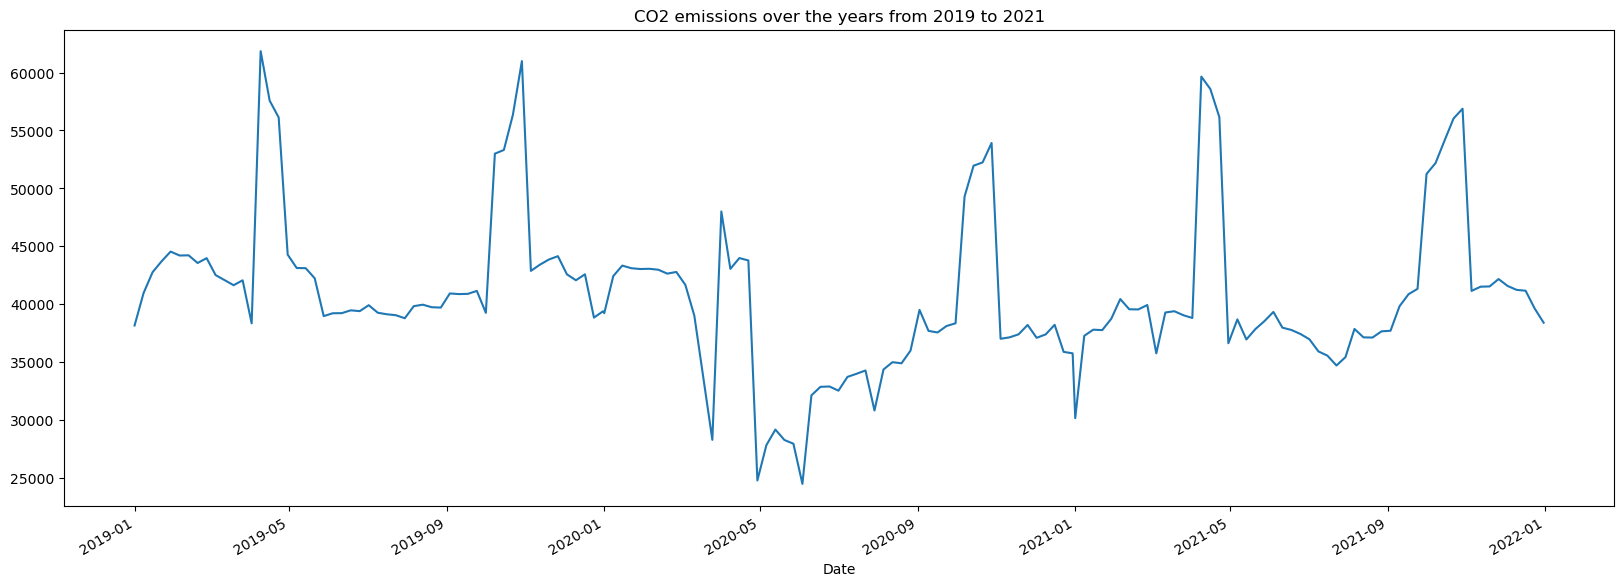

In [27]:
train_clean['date'] = pd.to_datetime(train_clean['year'], format="%Y") + pd.to_timedelta(train_clean['week_no'], unit="W")

train_clean.groupby(['date'])['emission'].sum().plot(kind='line', figsize=(20, 7), xlabel='Date')
plt.title("CO2 emissions over the years from 2019 to 2021")
plt.show()

From the plots, we can see that emmissions have a cyclic pattern (i.e. the emission tend to go up for 8-10 weeks and then drop for 8-10 weeks and repeat). This will be helpful to our model. Thus, we can add rolling average features to both the train and test set. We also notice that in 2020, the emissions did not closely follow the pattern as in 2019 and 2021, i.e. we have lower CO2 emissions in 2020 which makes sense because of the recent pandemic and most people were under lockdown. We can modify the emission in 2020 so that it can capture the pattern as in 2019 and 2021 which will be useful for predicting the emission in 2022 when things are back to normal now (and thus we expect the CO2 emissions in 2022 is similar to that of 2021).

In [28]:
ratios = train_clean[train_clean['year'].isin((2019,2021))].groupby('week_no')['emission'].mean() / train_clean[(train_clean['year']==2020)].groupby('week_no')['emission'].mean() 

train_clean.loc[train_clean['year'] == 2020, 'emission'] *= train_clean['week_no'].map(ratios)

In [29]:
train_clean['date'] = pd.to_datetime(train_clean['year'], format="%Y") + pd.to_timedelta(train_clean['week_no'], unit="W")
test_clean['date'] = pd.to_datetime(test_clean['year'], format="%Y") + pd.to_timedelta(test_clean['week_no'], unit="W")

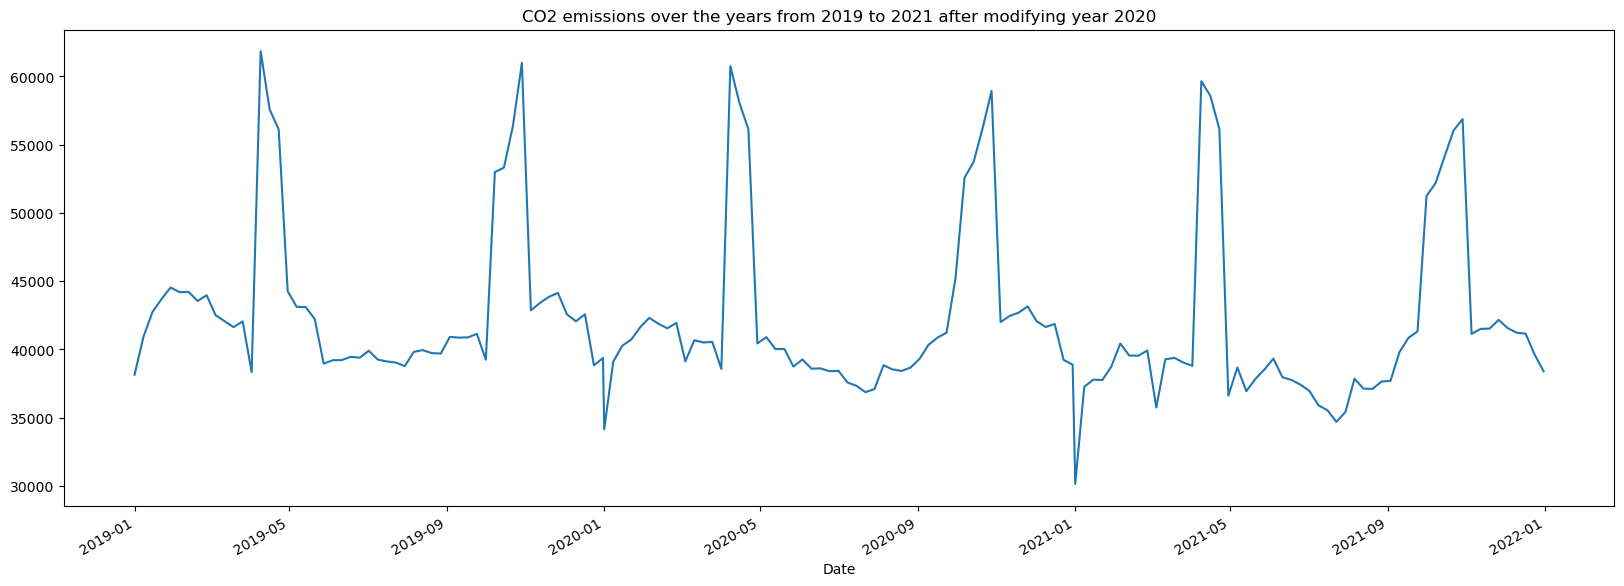

In [30]:
train_clean.groupby(['date'])['emission'].sum().plot(kind='line', figsize=(20, 7), xlabel='Date')
plt.title("CO2 emissions over the years from 2019 to 2021 after modifying year 2020")
plt.show()

In [31]:
# The shape of the data after the cleaning and engineering process
(train_clean.shape, test_clean.shape)

((79023, 37), (24353, 36))

<a id="#section-3"> </a>
## 3. Features Engineering and Scaling

### Reference 

- [[2] Getting Started: Modelling](https://www.kaggle.com/code/inversion/getting-started-modeling)
- [[3] Simple & Basic RandomForest CO2 Predictions](https://www.kaggle.com/code/krulll/simple-basic-randomforest-co2-predictions/notebook)
- [[4] Predict CO2 Emission in Rwanda](https://www.kaggle.com/code/roberttrypuz/predict-co2-emissions-in-rwanda)

In this section, we will perform data some feature engineering. Recall that the emissions over the years have a cyclic pattern which means that features that also have such pattern will be useful for us. To this end, we can apply the sin-cos scaling method.

In [32]:
train_clean_eng = train_clean.copy()
test_clean_eng = test_clean.copy()

In [33]:
# helper method that gives a sine and cosine encoding for latitude, longtitude, month, and week_no
def sin_cos_encode(data, max_week_val):
    
    data_eng = data.copy()
    data_eng['latitude_sin'] = np.sin(np.radians(data['latitude']))
    data_eng['latitude_cos'] = np.cos(np.radians(data['latitude']))
    data_eng['longitude_sin'] = np.sin(np.radians(data['longitude']))
    data_eng['longitude_cos'] = np.cos(np.radians(data['longitude']))
    
    data_eng['month_sin'] = np.sin(2 * np.pi * (data['month'] / 12))
    data_eng['month_cos'] = np.cos(2 * np.pi * (data['month'] / 12))
    
    data_eng['week_no_sin'] = np.sin(2 * np.pi * (data['week_no'] / max_week_val))
    data_eng['week_no_cos'] = np.cos(2 * np.pi * (data['week_no'] / max_week_val))
    
    return data_eng 

Month feature was not given but could be useful for our prediction (recall the graph showing the emission over time at the end of the previous section where we can also roughly examine the change of emission over the months in each year). 

In [34]:
train_clean_eng["month"] = train_clean_eng["date"].apply(lambda x:int(x.strftime('%m')))
test_clean_eng["month"] = test_clean_eng["date"].apply(lambda x:int(x.strftime('%m')))

In [35]:
train_clean_eng.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,CarbonMonoxide_CO_column_number_density,CarbonMonoxide_H2O_column_number_density,CarbonMonoxide_cloud_height,CarbonMonoxide_sensor_altitude,CarbonMonoxide_sensor_azimuth_angle,...,Ozone_cloud_fraction,Cloud_cloud_top_pressure,Cloud_cloud_top_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,emission,date,month
0,ID_-0.510_29.290_2019_00,-0.51000,29.29000,2019,0,0.03537,1589.02454,4061.09814,829530.50000,71.11198,...,0.59547,53534.73242,3664.43622,15.56853,0.27229,-12.62899,35.63242,3.75099,2019-01-01,1
1,ID_-0.510_29.290_2019_01,-0.51000,29.29000,2019,1,0.03653,1772.57441,1869.04041,829787.28713,-1.01959,...,0.17517,63790.29624,3651.19031,8.69060,0.25683,30.35938,39.55763,4.02518,2019-01-08,1
2,ID_-0.510_29.290_2019_02,-0.51000,29.29000,2019,2,0.03534,2703.23680,2809.13839,829883.82869,-54.80114,...,0.60609,55923.79055,4216.98649,21.10341,0.25110,15.37788,30.40182,4.23138,2019-01-15,1
3,ID_-0.510_29.290_2019_03,-0.51000,29.29000,2019,3,0.03679,2076.07333,3917.70787,829657.16357,28.91654,...,0.78740,44569.13064,5228.50774,15.38690,0.26204,-11.29340,24.38036,4.30529,2019-01-22,1
4,ID_-0.510_29.290_2019_04,-0.51000,29.29000,2019,4,0.03467,2053.60849,2667.31001,829735.09375,-12.50166,...,0.21574,59904.31484,3980.59812,8.11469,0.23585,38.53226,37.39298,4.34732,2019-01-29,1


In [36]:
_max_week_val_train = max(train_clean_eng["week_no"])
_max_week_val_test = max(test_clean_eng["week_no"])

train_clean_eng = sin_cos_encode(train_clean_eng, _max_week_val_train)
test_clean_eng = sin_cos_encode(test_clean_eng, _max_week_val_test) 

Lastly, we need to scale some features of the data. Notice that sine and cosine functions fluctuate between -1 and 1 while the year feature ranges from 2019 to 2022 which yields much bigger values compared to the rest of the feature. Thus, it might be helpful to scale the year feature down by subtracting by the min value, i.e. 2019

In [37]:
train_clean_eng["year_int"] = train_clean_eng["year"] - 2019
test_clean_eng["year_int"] = test_clean_eng["year"] - 2019

<a id="#section-4"> </a>
# 4. Model Selection

### Reference

- [[5] PS3E20 EDA + FE + ML Model](https://www.kaggle.com/code/ashx010/ps3e20-eda-fe-ml-model)

In this section, we will answer the question of which type of model we should choose for the tast. To this end, let us have a look at several models (Decision Tree Regressor, Random Forest Regressor, XGB Regressor, LGBM Regressor) to compare their performance. But first, let us create our training and testing set.

In [38]:
# keep the year for now to filter the train-test set, and then drop it right after
train_features = ['year', 'year_int', 'latitude_sin', 'longitude_sin', 'latitude_cos', 
                  'longitude_cos', 'week_no_sin', 'week_no_cos', 'month_sin', 'month_cos']
X = train_clean_eng[train_features]
y = train_clean_eng["emission"]

Now, we will split the training features and target values further based on years. Specifically, we will train our model on the data in 2019 and 2020, evaluate it on the data in 2021, and then at the end, perform the final prediction and submission on the data in 2022 which is the given test data.

In [39]:
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

train_index = X.query('year in (2019,2020)').index
test_index = X.query('year == 2021').index

X_train = X.iloc[train_index].drop(columns=['year'])
y_train = y.iloc[train_index]
X_test = X.iloc[test_index].drop(columns=['year'])
y_test = y.iloc[test_index]

In [40]:
(X_train.shape, X_test.shape)

((52682, 9), (26341, 9))

In [41]:
(y_train.shape, y_test.shape)

((52682,), (26341,))

In [42]:
X_train.head()

,year_int,latitude_sin,longitude_sin,latitude_cos,longitude_cos,week_no_sin,week_no_cos,month_sin,month_cos
0,0,-0.00890,0.48923,0.99996,0.87215,0.00000,1.00000,0.50000,0.86603
1,0,-0.00890,0.48923,0.99996,0.87215,0.12054,0.99271,0.50000,0.86603
2,0,-0.00890,0.48923,0.99996,0.87215,0.23932,0.97094,0.50000,0.86603
3,0,-0.00890,0.48923,0.99996,0.87215,0.35460,0.93502,0.50000,0.86603
4,0,-0.00890,0.48923,0.99996,0.87215,0.46472,0.88546,0.50000,0.86603


In [43]:
X_train.describe(include='all')

,year_int,latitude_sin,longitude_sin,latitude_cos,longitude_cos,week_no_sin,week_no_cos,month_sin,month_cos
count,52682.00000,52682.00000,52682.00000,52682.00000,52682.00000,52682.00000,52682.00000,52682.00000,52682.00000
mean,0.50000,-0.03300,0.49814,0.99938,0.86698,0.00000,0.01887,-0.00126,0.01415
std,0.50000,0.01211,0.01226,0.00041,0.00705,0.70041,0.71350,0.70209,0.71196
min,0.00000,-0.05755,0.47298,0.99834,0.85235,-1.00000,-1.00000,-1.00000,-1.00000
25%,0.00000,-0.04276,0.48880,0.99909,0.86189,-0.66312,-0.66312,-0.50000,-0.50000
50%,0.50000,-0.03284,0.49823,0.99946,0.86704,0.00000,0.00000,-0.00000,-0.00000
75%,1.00000,-0.02274,0.50710,0.99974,0.87239,0.66312,0.74851,0.50000,0.86603
max,1.00000,-0.00890,0.52297,0.99996,0.88107,1.00000,1.00000,1.00000,1.00000


In [44]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

y_train_normal = np.cbrt(y_train)
y_test_normal = np.cbrt(y_test)

Let us build a base model using the default parameters and evaluate it.

In [45]:
# helper method that computes the RMSE and R2 score on test data

def evaluate(model, test_features, test_labels):
    
    pred = model.predict(test_features)
    
    rmse = mean_squared_error(test_labels, pred, squared=False)
    r2 = r2_score(test_labels, pred)
    
    return [rmse, r2]

In [46]:
dt_reg = DecisionTreeRegressor()
dt_reg.fit(X_train, y_train_normal)

dt_reg_scores = evaluate(dt_reg, X_test, y_test_normal)

print("For the Decision Tree Regressor model")
print("\tRMSE = ", dt_reg_scores[0])
print("\tR2 = ", dt_reg_scores[1])

For the Decision Tree Regressor model
	RMSE =  0.18073884748221924
	R2 =  0.9907093268293755


In [47]:
rf_reg = RandomForestRegressor()
rf_reg.fit(X_train, y_train_normal)

rf_reg_scores = evaluate(rf_reg, X_test, y_test_normal)

print("For the Random Forest Regressor model")
print("\tRMSE = ", rf_reg_scores[0])
print("\tR2 = ", rf_reg_scores[1])

For the Random Forest Regressor model
	RMSE =  0.16280956259181067
	R2 =  0.992461169403305


In [48]:
xgb_reg = XGBRegressor()
xgb_reg.fit(X_train, y_train_normal)

xgb_reg_scores = evaluate(xgb_reg, X_test, y_test_normal)

print("For the XGB Regressor model")
print("\tRMSE = ", xgb_reg_scores[0])
print("\tR2 = ", xgb_reg_scores[1])

For the XGB Regressor model
	RMSE =  0.20429210255268712
	R2 =  0.9881300928498378


In [49]:
base_params = {
    
    'objective': 'regression',
    'boosting_type': 'gbdt',
    'metric': 'mean_squared_error',
    'verbosity': -1
}

# Create the LightGBM model
lgbm_reg = lgb.LGBMRegressor(**base_params)
lgbm_reg.fit(X_train, y_train_normal)

lgbm_reg_scores = evaluate(lgbm_reg, X_test, y_test_normal)

print("For the LGBM Regressor model")
print("\tRMSE = ", lgbm_reg_scores[0])
print("\tR2 = ", lgbm_reg_scores[1])

For the LGBM Regressor model
	RMSE =  0.4187699734988526
	R2 =  0.9501235844735798


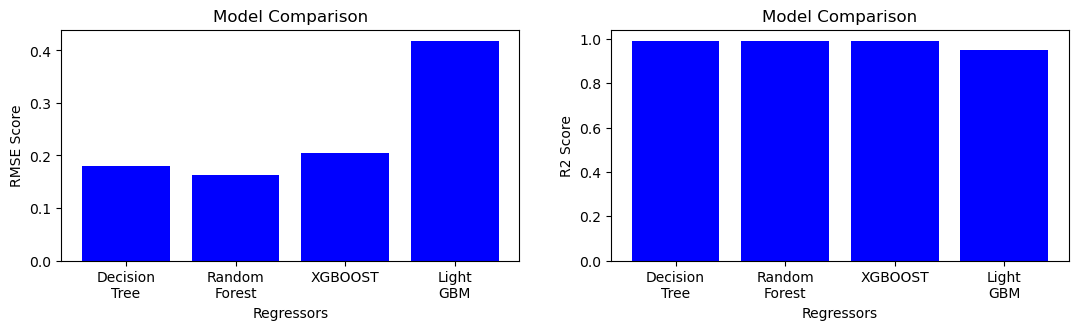

In [50]:
rmse_scores = [dt_reg_scores[0], rf_reg_scores[0], xgb_reg_scores[0], lgbm_reg_scores[0]]
r2_scores = [dt_reg_scores[1], rf_reg_scores[1], xgb_reg_scores[1], lgbm_reg_scores[1]]

fig = plt.figure(figsize=(13, 3))

axs1 = fig.add_subplot(1, 2, 1)
axs1.bar(['Decision\nTree','Random\nForest', 'XGBOOST', 'Light\nGBM'],
             rmse_scores, color = 'blue')

axs1.set_ylabel('RMSE Score')
axs1.set_xlabel('Regressors')
axs1.set_title('Model Comparison')

axs2 = fig.add_subplot(1, 2, 2)
axs2.bar(['Decision\nTree','Random\nForest', 'XGBOOST', 'Light\nGBM'],
             r2_scores, color = 'blue')

axs2.set_ylabel('R2 Score')
axs2.set_xlabel('Regressors')
axs2.set_title('Model Comparison')

plt.show()

From the plot above, it seems like our best choice for mofelling among the 4 proposed options is **Random Forest Regression**.

<a id="#section-5"> </a>
# 5. Model Development

### Reference:

- [[2] Getting Started: Modelling](https://www.kaggle.com/code/inversion/getting-started-modeling)
- [[3] Simple & Basic RandomForest CO2 Predictions](https://www.kaggle.com/code/krulll/simple-basic-randomforest-co2-predictions/notebook)
- [[6] Hyperparameter Tuning the Random Forest in Python](https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74)

In this section, we build and train our model. From our observation in the previous section, we will use the Random Forest Regressor. First, let start with a base model using the default parameters.

In [51]:
# Train a base model using default parameters 

rfr_base = RandomForestRegressor(n_jobs=-1,verbose=1)
rfr_base.fit(X_train, y_train_normal)

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   18.9s finished


RandomForestRegressor(n_jobs=-1, verbose=1)

In [52]:
# Evaluate the base model
rmse_base, r2_base = evaluate(rfr_base, X_test, y_test_normal)

print("For the base model")
print("\tRMSE = ", rmse_base)
print("\tR2 = ", r2_base)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


For the base model
	RMSE =  0.162687172289912
	R2 =  0.9924724996093546


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished


Not bad! Now, we will fine-tune the parameters using grid search to see if we get any improvement. Random Forest Regressor is a complicated model that involes lots of parameters. This means that we have tons of combinations of parameters to try out which can be very time consuming. However, the performance of the base model where the default parameters were use was quite decent, so we can narrow our search space to only values that are close to the default ones.

In [53]:
# Create the parameter grid based on the results of random search 
# Change accordingly based on the result of the base model search above
# Don't want to add too many values for each paramemter since training takes a while...

param_grid = {
    'bootstrap': [True, False],
    'max_depth': [None],
    'max_features': [1.0],
    'min_samples_leaf': [1, 3, 5],
    'min_samples_split': [2, 4, 6],
    'n_estimators': [100, 150, 200]
}

# Create a based model
rf = RandomForestRegressor()

# Instantiate the grid search model
rf_grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 5, n_jobs = -1, verbose = 1)

# Fit the grid search to the data
rf_grid_search.fit(X_train, y_train_normal)

rf_grid_search.best_params_

Fitting 5 folds for each of 54 candidates, totalling 270 fits


{'bootstrap': True,
 'max_depth': None,
 'max_features': 1.0,
 'min_samples_leaf': 5,
 'min_samples_split': 6,
 'n_estimators': 200}

In [54]:
# Evaluate the model from deterministic grid search

best_grid_search = rf_grid_search.best_estimator_
grid_search_scores = evaluate(best_grid_search, X_test, y_test_normal)

print("For the model from grid search")
print("\tRMSE = ", grid_search_scores[0])
print("\tR2 = ", grid_search_scores[1])

For the model from grid search
	RMSE =  0.1676178298128246
	R2 =  0.9920093042985154


<a id="#section-6"> </a>
# 6. Final Evaluation & Submission

In this section, we will build the final model for submission. We use the best parameters found in the section above, train the model on the full given training data, and then predict the CO2 emissions in 2022.

In [55]:
X = X.to_numpy()
y_normal = np.cbrt(y)

In [56]:
# define the final parameters
f_bootstrap = True
f_max_depth = None
f_max_features = 1.0
f_min_samples_leaf = 5
f_min_samples_split = 4
f_n_estimators = 150

In [57]:
# Train the final model on the full data
rfr_final = RandomForestRegressor(n_estimators = f_n_estimators, 
                                  max_depth = f_max_depth,
                                  min_samples_split = f_min_samples_split,
                                  min_samples_leaf = f_min_samples_leaf,
                                  max_features = f_max_features,
                                  n_jobs=-1, verbose=1)
rfr_final.fit(X, y_normal)

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   35.1s finished


RandomForestRegressor(min_samples_leaf=5, min_samples_split=4, n_estimators=150,
                      n_jobs=-1, verbose=1)

In [58]:
# Make the prediction
X_test_final = test_clean_eng[train_features].to_numpy()

y_sub_pred = rfr_final.predict(X_test_final)
np.power(y_sub_pred, 3) 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.4s finished


array([ 3.72046419,  3.91733567,  4.05586869, ..., 27.95427678,
       26.40875083, 26.30852317])

In [59]:
# Create the submission file
submission = pd.DataFrame({'ID_LAT_LON_YEAR_WEEK': test_clean_eng.ID_LAT_LON_YEAR_WEEK, 
                           'emission': np.power(y_sub_pred, 3)})

# post-processing, fix the negative emission (which is not allowed) to 0
submission.loc[submission['emission'] < 0 , "emission"] = 0 
submission.head()

,ID_LAT_LON_YEAR_WEEK,emission
0,ID_-0.510_29.290_2022_00,3.72046
1,ID_-0.510_29.290_2022_01,3.91734
2,ID_-0.510_29.290_2022_02,4.05587
3,ID_-0.510_29.290_2022_03,4.09794
4,ID_-0.510_29.290_2022_04,4.14670


In [60]:
# Save the submission file to working folder
submission.to_csv('submission.csv', index = False)

<a id="#section-7"> </a>
# 7. Potential Improvement

The best score that I got for the current version was around 35 (for public score) and 27.1 (for private score) which would take me to approximately the middle of the leaderboard (too bad I didn't get to submit this score before the deadline and what was publicly shown for me was a much more horrible score on the leaderboard, oops...) 

In this section, we take a look at some potential improvements for the prediction (at least some improvements that I could think of). 

- Choose more features besides the longtitude, latitude, and time, perhaps those that are correlated with the target value, and then scale the data appropriately once more features are chosen. The given data may consists anomalies that I missed (i.e. inconsistent entries, typos, etc.).

- Handle skewness of features. Only the skewness of the target value was handled in the current work.

- Try other feature engineering methods. This may require examining the data more carefully than what was done above to see if we can engineer something meaningful. [[5]](https://www.kaggle.com/code/ashx010/ps3e20-eda-fe-ml-model#Data-Preprocessing) suggested a pretty neat trick of using KMean Clustering to engineer a new feature.

- Expand the pool of possible models that one can choose. I only had 4 models for my pool above, but perhaps one can add other fancy stuff like Cat Boost Regression or LAD Regression to the pool.

- Maybe more can be done with the prediction afterwards (i.e. post-processing). So far I only converted the negative prediction to 0 simply because emission value can't be negative. [[4]](https://www.kaggle.com/code/roberttrypuz/predict-co2-emissions-in-rwanda#Pre--and-postprocessing) brought up a nice post-processing method that involes multiple steps. Specifically, one can

    - Consider the mean of the past emissions as shown [here](https://www.kaggle.com/code/kdmitrie/pgs320-the-shortest-solution-lb-22-97) and [here](https://www.kaggle.com/code/yakubsadlil/7-lines-code-higher-score) 
    - Consider the growing factor of 1.065 of the target values throughout the year as discussed [here](https://www.kaggle.com/competitions/playground-series-s3e20/discussion/428791)
    - Fix the longtitude value of 29.321 as discussed [here](https://www.kaggle.com/competitions/playground-series-s3e20/discussion/429717)
    - Consider the 15 locations have zero CO2 emissions; all are present in the test set as discussed [here](https://www.kaggle.com/competitions/playground-series-s3e20/discussion/428566)
    